In [1]:
%pip install xgboost
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pathlib import Path

from src.models.binary_classifier import BinaryTrafficClassifier, evaluate_model_performance

print("Запуск бинарной классификации")

# Загрузка подготовленных данных
print("Загрузка данных...")
X_normalized = pd.read_parquet('../data/processed/X_normalized.parquet')
y_binary = pd.read_parquet('../data/processed/y_binary.parquet')['label']

print(f"Признаки: {X_normalized.shape}")
print(f"Метки: {y_binary.shape}")
print(f"Распределение классов: {y_binary.value_counts().to_dict()}")

Note: you may need to restart the kernel to use updated packages.
Запуск бинарной классификации
Загрузка данных...
Признаки: (257673, 49)
Метки: (257673,)
Распределение классов: {1: 164673, 0: 93000}



Разделение данных
Тренировочная выборка: (206138, 49)
Тестовая выборка: (51535, 49)
Распределение в тренировочной: {1: 131738, 0: 74400}
Распределение в тестовой: {1: 32935, 0: 18600}


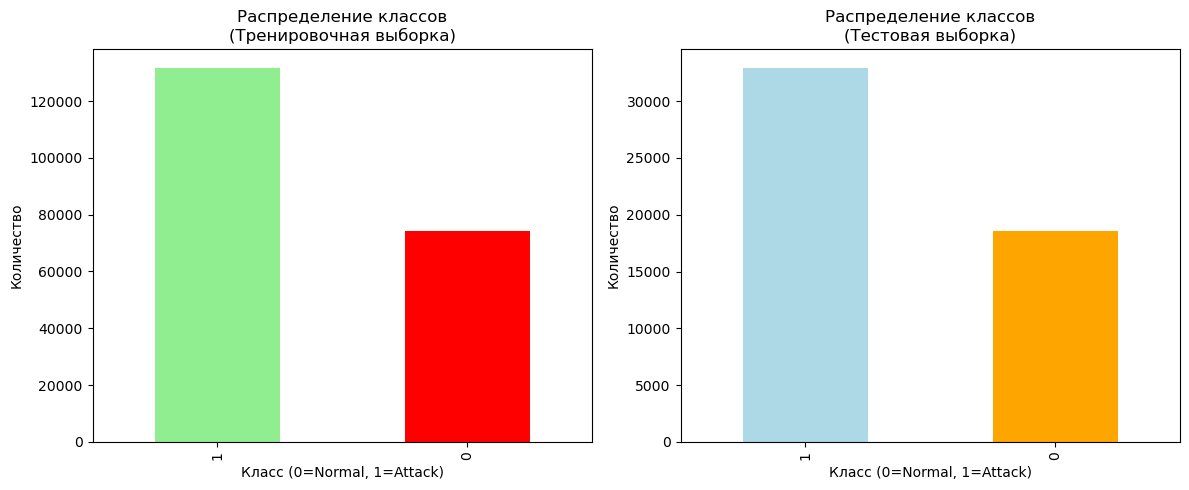

In [2]:
# Разделение на тренировочную и тестовую выборки
print("\nРазделение данных")
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_binary, 
    test_size=0.2, 
    random_state=42,
    stratify=y_binary  # сохраняем распределение классов
)

print(f"Тренировочная выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"Распределение в тренировочной: {y_train.value_counts().to_dict()}")
print(f"Распределение в тестовой: {y_test.value_counts().to_dict()}")

# Визуализация распределения классов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Тренировочная выборка
y_train.value_counts().plot(kind='bar', ax=ax1, color=['lightgreen', 'red'])
ax1.set_title('Распределение классов\n(Тренировочная выборка)')
ax1.set_xlabel('Класс (0=Normal, 1=Attack)')
ax1.set_ylabel('Количество')

# Тестовая выборка
y_test.value_counts().plot(kind='bar', ax=ax2, color=['lightblue', 'orange'])
ax2.set_title('Распределение классов\n(Тестовая выборка)')
ax2.set_xlabel('Класс (0=Normal, 1=Attack)')
ax2.set_ylabel('Количество')

plt.tight_layout()
plt.savefig('../reports/figures/class_distribution_split.png', dpi=300, bbox_inches='tight')
plt.show()

In [3]:
classifier = BinaryTrafficClassifier()
classifier.initialize_models()

# Обучение всех моделей
results = classifier.train_models(X_train, y_train, X_test, y_test)

Модели инициализированы

	Обучение LogisticRegression...
		LogisticRegression: Accuracy = 0.8506, AUC = 0.9477

	Обучение RandomForest...
		RandomForest: Accuracy = 0.9231, AUC = 0.9858

	Обучение XGBoost...
		XGBoost: Accuracy = 0.9309, AUC = 0.9871

	Обучение GradientBoosting...
		GradientBoosting: Accuracy = 0.9357, AUC = 0.9882

 ЛУЧШАЯ МОДЕЛЬ: GradientBoosting (AUC = 0.9882)



ДЕТАЛЬНАЯ ОЦЕНКА: GradientBoosting

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     18600
           1       0.95      0.95      0.95     32935

    accuracy                           0.94     51535
   macro avg       0.93      0.93      0.93     51535
weighted avg       0.94      0.94      0.94     51535



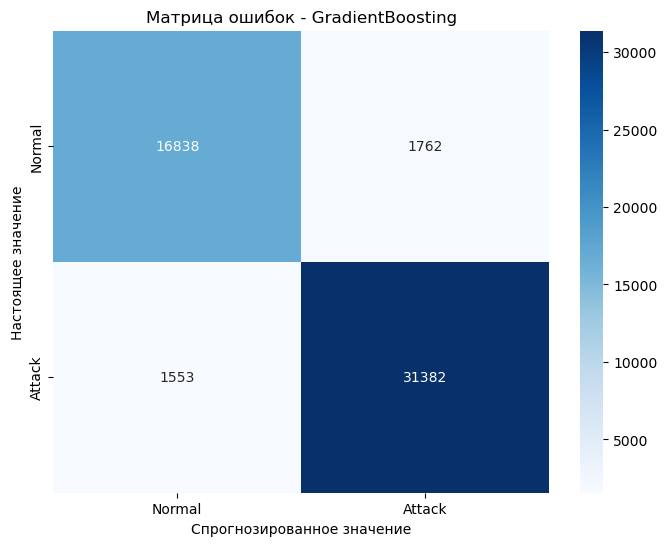

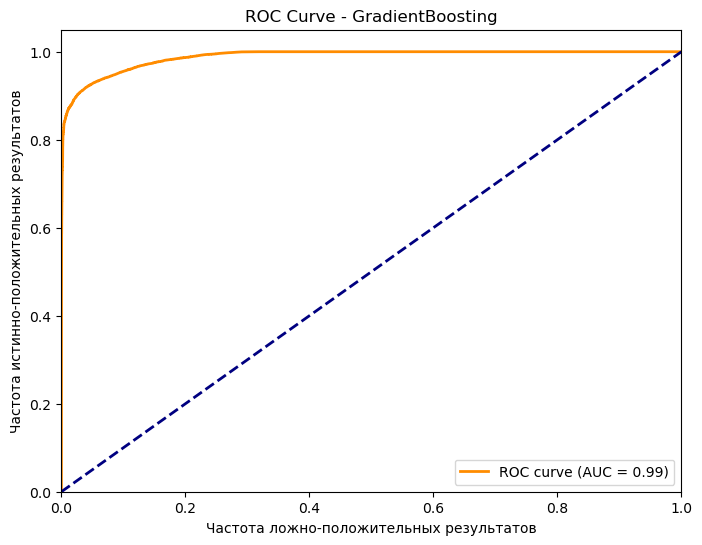


Топ-15 самых важных признаков:
                              feature  importance
7               num__remainder__dload    0.409322
20             num__remainder__ackdat    0.157250
6               num__remainder__sload    0.100512
3              num__remainder__sbytes    0.065854
21              num__remainder__smean    0.055683
1               num__remainder__spkts    0.033388
4              num__remainder__dbytes    0.024669
32        remainder__cat__proto_other    0.017180
22              num__remainder__dmean    0.015785
18             num__remainder__tcprtt    0.015725
24  num__remainder__response_body_len    0.013665
37        remainder__cat__service_dns    0.010958
19             num__remainder__synack    0.010111
36          remainder__cat__service_-    0.009979
8               num__remainder__sloss    0.009743


C:\Users\ro517\AppData\Local\Temp\ipykernel_5236\2103731234.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


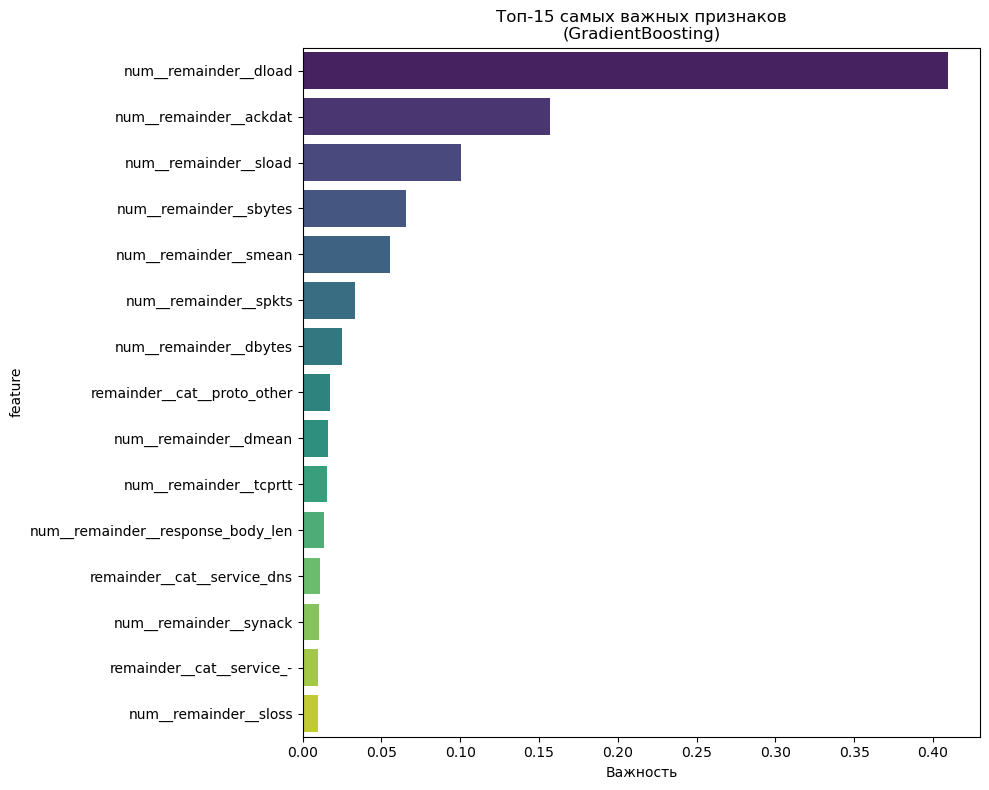

In [4]:
best_result = results[classifier.best_model_name]
detailed_metrics = evaluate_model_performance(
    y_test, 
    best_result['y_pred'], 
    best_result['y_pred_proba'], 
    classifier.best_model_name
)
# Анализ важности признаков для интерпретируемых моделей
top_features = classifier.get_feature_importance(X_normalized.columns, top_n=15)

if top_features is not None:
    # Визуализация важности признаков
    plt.figure(figsize=(10, 8))
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title(f'Топ-15 самых важных признаков\n({classifier.best_model_name})')
    plt.xlabel('Важность')
    plt.tight_layout()
    plt.savefig('../reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()


Сравнение всех моделей

Лучшие модели:
                Model  Accuracy  AUC_Score
3    GradientBoosting  0.935675   0.988168
2             XGBoost  0.930882   0.987078
1        RandomForest  0.923081   0.985783
0  LogisticRegression  0.850645   0.947733


C:\Users\ro517\AppData\Local\Temp\ipykernel_5236\2611509734.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x='Accuracy', y='Model', ax=ax1, palette='Blues_d')
C:\Users\ro517\AppData\Local\Temp\ipykernel_5236\2611509734.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x='AUC_Score', y='Model', ax=ax2, palette='Reds_d')


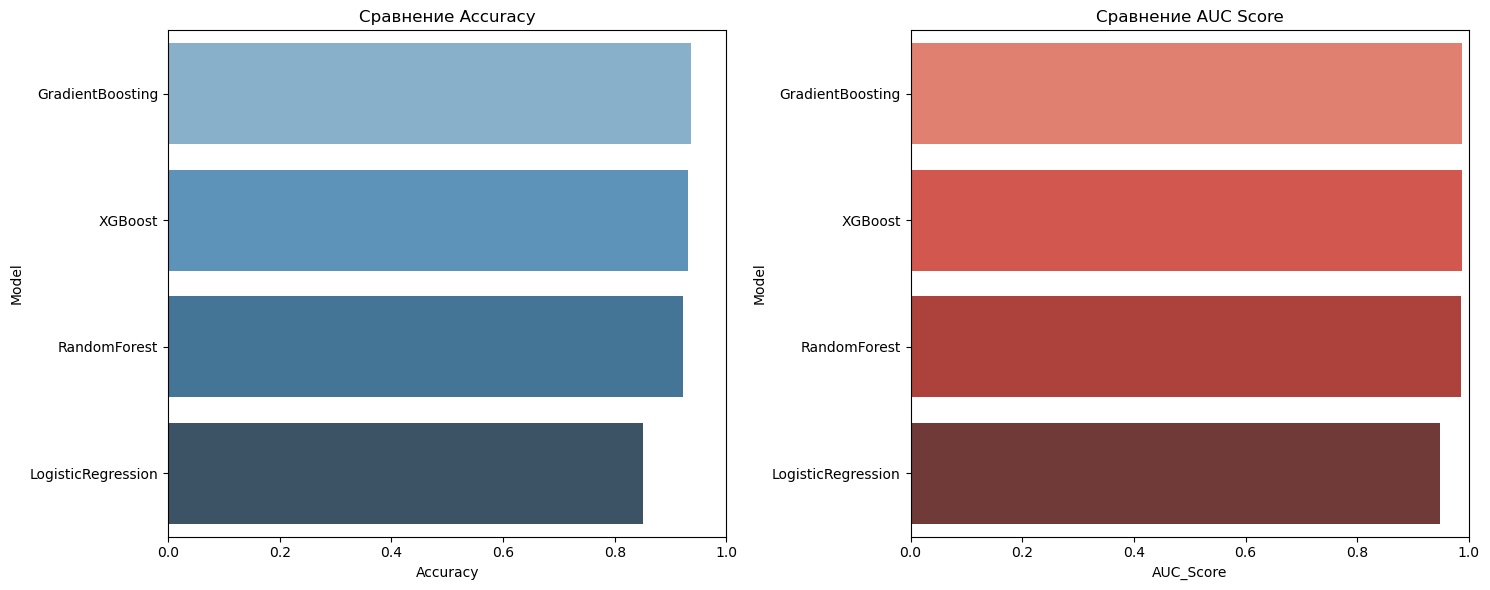

In [5]:
# Сравнительный анализ всех моделей
print("\nСравнение всех моделей")

# Создаем DataFrame с результатами
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'AUC_Score': [results[name]['auc_score'] for name in results.keys()]
}).sort_values('AUC_Score', ascending=False)

print("\nЛучшие модели:")
print(comparison_df)

# Визуализация сравнения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
sns.barplot(data=comparison_df, x='Accuracy', y='Model', ax=ax1, palette='Blues_d')
ax1.set_title('Сравнение Accuracy')
ax1.set_xlim(0, 1)

# AUC comparison
sns.barplot(data=comparison_df, x='AUC_Score', y='Model', ax=ax2, palette='Reds_d')
ax2.set_title('Сравнение AUC Score')
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Сохранение результатов
models_path = Path("../models")

reports_path = Path("../reports")

# Сохраняем лучшую модель
classifier.save_best_model(models_path / "best_binary_classifier.joblib")

# Сохраняем сравнение моделей
comparison_df.to_csv(reports_path / "model_comparison.csv", index=False)

# Сохраняем детальные метрики лучшей модели (ИСПРАВЛЕННАЯ ВЕРСИЯ)
def convert_metrics_for_json(metrics):
    """Конвертирует numpy массивы в списки для JSON сериализации"""
    json_metrics = {}
    
    for key, value in metrics.items():
        if hasattr(value, 'tolist'):  # для numpy массивов
            json_metrics[key] = value.tolist()
        elif isinstance(value, dict):
            json_metrics[key] = {}
            for sub_key, sub_value in value.items():
                if hasattr(sub_value, 'tolist'):
                    json_metrics[key][sub_key] = sub_value.tolist()
                else:
                    json_metrics[key][sub_key] = sub_value
        else:
            json_metrics[key] = value
    
    return json_metrics

# Конвертируем и сохраняем метрики
if 'detailed_metrics' in locals():
    json_metrics = convert_metrics_for_json(detailed_metrics)
    import json
    with open(reports_path / "best_model_metrics.json", 'w') as f:
        json.dump(json_metrics, f, indent=2)
    print("Метрики модели сохранены")

print("Все результаты сохранены")

	Лучшая модель сохранена: ..\models\best_binary_classifier.joblib
Метрики модели сохранены
Все результаты сохранены


In [10]:
report = f"""
ОТЧЕТ ПО БИНАРНОЙ КЛАССИФИКАЦИИ

ДАННЫЕ:
- Общее количество записей: {len(X_normalized)}
- Количество признаков: {X_normalized.shape[1]}
- Тренировочная выборка: {X_train.shape[0]} записей
- Тестовая выборка: {X_test.shape[0]} записей
- Распределение классов: {y_binary.value_counts().to_dict()}

РЕЗУЛЬТАТЫ:
- Лучшая модель: {classifier.best_model_name}
- Accuracy лучшей модели: {results[classifier.best_model_name]['accuracy']:.4f}
- AUC Score лучшей модели: {results[classifier.best_model_name]['auc_score']:.4f}

СРАВНЕНИЕ МОДЕЛЕЙ:
"""

for model_name in comparison_df['Model']:
    report += f"- {model_name}: Accuracy = {results[model_name]['accuracy']:.4f}, AUC = {results[model_name]['auc_score']:.4f}\n"

report += f"""
СОХРАНЕННЫЕ ФАЙЛЫ:
1. models/best_binary_classifier.joblib - лучшая модель
2. reports/model_comparison.csv - сравнение моделей  
3. reports/best_model_metrics.json - детальные метрики
4. reports/figures/ - визуализации

ВЫВОД:
Бинарная классификация завершена успешно! Модель готова к обнаружению сетевых атак.
"""

print(report)

# Сохраняем отчет
with open(reports_path / "binary_classification_report.txt", "w", encoding='utf-8') as f:
    f.write(report)


ОТЧЕТ ПО БИНАРНОЙ КЛАССИФИКАЦИИ

ДАННЫЕ:
- Общее количество записей: 257673
- Количество признаков: 49
- Тренировочная выборка: 206138 записей
- Тестовая выборка: 51535 записей
- Распределение классов: {1: 164673, 0: 93000}

РЕЗУЛЬТАТЫ:
- Лучшая модель: GradientBoosting
- Accuracy лучшей модели: 0.9357
- AUC Score лучшей модели: 0.9882

СРАВНЕНИЕ МОДЕЛЕЙ:
- GradientBoosting: Accuracy = 0.9357, AUC = 0.9882
- XGBoost: Accuracy = 0.9309, AUC = 0.9871
- RandomForest: Accuracy = 0.9231, AUC = 0.9858
- LogisticRegression: Accuracy = 0.8506, AUC = 0.9477

СОХРАНЕННЫЕ ФАЙЛЫ:
1. models/best_binary_classifier.joblib - лучшая модель
2. reports/model_comparison.csv - сравнение моделей  
3. reports/best_model_metrics.json - детальные метрики
4. reports/figures/ - визуализации

ВЫВОД:
Бинарная классификация завершена успешно! Модель готова к обнаружению сетевых атак.

